## Libraries

In [1]:
import sys
sys.path.append('./venv/lib/python3.6/site-packages')

In [2]:
import os
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

In [3]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms as vtransforms
from torchvision import utils as vutils
from torchvision import datasets

In [4]:
from gans.utils.data import CartoonSet
from gans.utils.layers import *
from gans.utils.functions import *
from gans.models import *
from gans.trainer import *

## Random seed

In [5]:
# Set random seem for reproducibility
manualSeed = 123
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


## Inputs

In [6]:
# Dataset
data_root = './datasets'

# data_name = 'FashionMNIST'
# data_name = 'MNIST'

# batch_size = 200
# sample_size = 50
# nrow = 5

data_name = 'CartoonSet'

batch_size = 128
sample_size = 32
nrow = 4

num_epochs = 100

num_workers = 8


# Output dir
output_root = './output/dcGAN'
# overwrite real sample output
overwrite_real = False

noize_dim = 100

# Optimization parameters
lr = 0.001
beta1 = 0.5

## Device

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('using device: ', device)

using device:  cuda:0


## Dataset

In [8]:
img_size = 28
in_channels = 1

if data_name == 'CartoonSet':
    img_size = 75
    dataset = CartoonSet(root=os.path.join(data_root, data_name), 
                         transform=vtransforms.Compose([
                             vtransforms.CenterCrop(size=400),
                             vtransforms.Resize(size=img_size), 
                             vtransforms.ToTensor(),
                             vtransforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                         ]))
    
elif data_name == 'MNIST':
    dataset = datasets.MNIST(root=os.path.join(data_root, data_name), 
                             download=True,
                             transform=vtransforms.Compose([
                                 vtransforms.ToTensor(),
                                 vtransforms.Normalize((0.5,), (0.5,)),
                         ]))
elif data_name == 'FashionMNIST':
    dataset = datasets.FashionMNIST(root=os.path.join(data_root, data_name), 
                                    download=True,
                                    transform=vtransforms.Compose([
                                        vtransforms.ToTensor(),
                                        vtransforms.Normalize((0.5,), (0.5,)),
                                    ]))
    
dtype = dataset[0][0].dtype
img_shape = dataset[0][0].shape

## Dataloader

In [9]:
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         shuffle=True, 
                                         num_workers=num_workers)

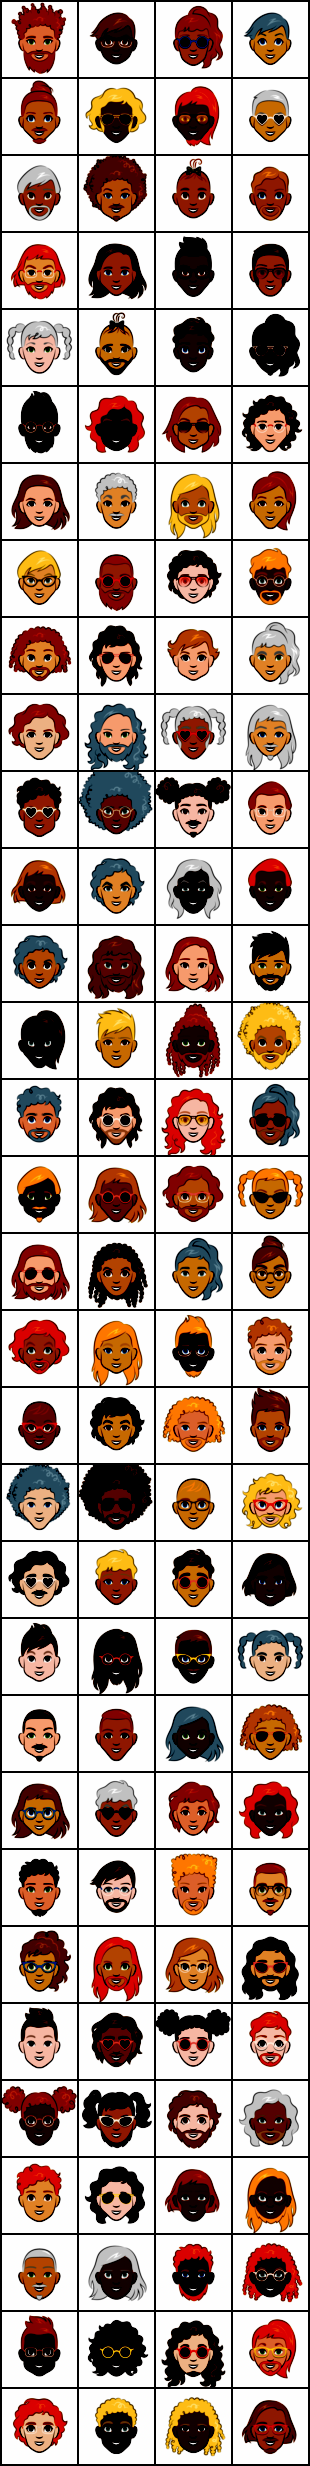

In [10]:
if not os.path.exists(os.path.join(output_root, data_name)):
    os.makedirs(os.path.join(output_root, data_name))

real_sample_path = os.path.join(output_root, data_name, 'real_samples.png')


real_batch = next(iter(dataloader))

vutils.save_image(real_batch[0], real_sample_path, 
                  normalize=True, range=(0,1), nrow=nrow)
Image(real_sample_path)

## Model

In [11]:
netG = DCGenerator(img_shape=img_shape, noize_dim=noize_dim).to(device)
print(netG)

DCGenerator(
  (model): Sequential(
    (0): Unflatten2d(img_shape=(100, 1, 1))
    (1): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): Tanh()
  )
)


In [12]:
netD = DCDiscriminator(img_shape=img_shape).to(device)
print(netD)

DCDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.1, inplace)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1, inplace)
    (8): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
    (13): Flatten()
  )
)


## Training

In [13]:
trainer = GANTrainer(generator=netG, discriminator=netD,
                     optimizer=optim.Adam, loss=nn.BCELoss(), 
                     device='cuda:0', multi_gpu=False, output_path=os.path.join(output_root, data_name),
                     batch_size=batch_size, num_epochs=num_epochs, sample_size=sample_size)

In [14]:
trainer.train(dataloader=dataloader, nrow=nrow)

/home/shu/.local/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[Epoch 0/100][Batch 0/79] Loss_D: 1.47 Loss_G: 23.40
[Epoch 0/100][Batch 15/79] Loss_D: 0.00 Loss_G: 32.16
[Epoch 0/100][Batch 30/79] Loss_D: 0.01 Loss_G: 5.82
[Epoch 0/100][Batch 45/79] Loss_D: 0.06 Loss_G: 4.86
[Epoch 0/100][Batch 60/79] Loss_D: 1.64 Loss_G: 14.29
[Epoch 0/100][Batch 75/79] Loss_D: 0.00 Loss_G: 14.78
Epoch 0 running time: 18.89


/home/shu/.local/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[Epoch 1/100][Batch 0/79] Loss_D: 0.03 Loss_G: 5.57
[Epoch 1/100][Batch 15/79] Loss_D: 0.06 Loss_G: 4.57
[Epoch 1/100][Batch 30/79] Loss_D: 0.06 Loss_G: 7.73
[Epoch 1/100][Batch 45/79] Loss_D: 0.02 Loss_G: 5.49
[Epoch 1/100][Batch 60/79] Loss_D: 0.00 Loss_G: 7.03
[Epoch 1/100][Batch 75/79] Loss_D: 7.19 Loss_G: 22.20
Epoch 1 running time: 19.04
[Epoch 2/100][Batch 0/79] Loss_D: 0.00 Loss_G: 9.81
[Epoch 2/100][Batch 15/79] Loss_D: 0.07 Loss_G: 11.10
[Epoch 2/100][Batch 30/79] Loss_D: 1.02 Loss_G: 8.63
[Epoch 2/100][Batch 45/79] Loss_D: 1.25 Loss_G: 13.51
[Epoch 2/100][Batch 60/79] Loss_D: 0.00 Loss_G: 4.68
[Epoch 2/100][Batch 75/79] Loss_D: 0.00 Loss_G: 9.20
Epoch 2 running time: 19.22
[Epoch 3/100][Batch 0/79] Loss_D: 0.02 Loss_G: 5.10
[Epoch 3/100][Batch 15/79] Loss_D: 0.04 Loss_G: 3.87
[Epoch 3/100][Batch 30/79] Loss_D: 0.01 Loss_G: 6.13
[Epoch 3/100][Batch 45/79] Loss_D: 0.11 Loss_G: 6.89
[Epoch 3/100][Batch 60/79] Loss_D: 0.00 Loss_G: 7.71
[Epoch 3/100][Batch 75/79] Loss_D: 0.11 Los

[Epoch 24/100][Batch 45/79] Loss_D: 0.21 Loss_G: 3.97
[Epoch 24/100][Batch 60/79] Loss_D: 0.09 Loss_G: 5.85
[Epoch 24/100][Batch 75/79] Loss_D: 0.05 Loss_G: 4.57
Epoch 24 running time: 19.60
[Epoch 25/100][Batch 0/79] Loss_D: 0.69 Loss_G: 16.61
[Epoch 25/100][Batch 15/79] Loss_D: 0.35 Loss_G: 8.23
[Epoch 25/100][Batch 30/79] Loss_D: 0.07 Loss_G: 5.36
[Epoch 25/100][Batch 45/79] Loss_D: 0.09 Loss_G: 5.30
[Epoch 25/100][Batch 60/79] Loss_D: 0.07 Loss_G: 5.32
[Epoch 25/100][Batch 75/79] Loss_D: 0.07 Loss_G: 5.70
Epoch 25 running time: 19.77
[Epoch 26/100][Batch 0/79] Loss_D: 0.09 Loss_G: 7.88
[Epoch 26/100][Batch 15/79] Loss_D: 0.03 Loss_G: 6.49
[Epoch 26/100][Batch 30/79] Loss_D: 0.05 Loss_G: 6.03
[Epoch 26/100][Batch 45/79] Loss_D: 0.11 Loss_G: 6.81
[Epoch 26/100][Batch 60/79] Loss_D: 1.29 Loss_G: 0.31
[Epoch 26/100][Batch 75/79] Loss_D: 0.39 Loss_G: 8.42
Epoch 26 running time: 19.63
[Epoch 27/100][Batch 0/79] Loss_D: 0.62 Loss_G: 7.43
[Epoch 27/100][Batch 15/79] Loss_D: 0.15 Loss_G: 4.

[Epoch 47/100][Batch 75/79] Loss_D: 0.00 Loss_G: 8.94
Epoch 47 running time: 19.29
[Epoch 48/100][Batch 0/79] Loss_D: 0.00 Loss_G: 9.15
[Epoch 48/100][Batch 15/79] Loss_D: 0.00 Loss_G: 9.55
[Epoch 48/100][Batch 30/79] Loss_D: 0.00 Loss_G: 9.85
[Epoch 48/100][Batch 45/79] Loss_D: 0.00 Loss_G: 9.26
[Epoch 48/100][Batch 60/79] Loss_D: 0.00 Loss_G: 8.57
[Epoch 48/100][Batch 75/79] Loss_D: 0.00 Loss_G: 9.77
Epoch 48 running time: 19.40
[Epoch 49/100][Batch 0/79] Loss_D: 0.00 Loss_G: 10.11
[Epoch 49/100][Batch 15/79] Loss_D: 0.00 Loss_G: 9.51
[Epoch 49/100][Batch 30/79] Loss_D: 0.00 Loss_G: 10.59
[Epoch 49/100][Batch 45/79] Loss_D: 0.00 Loss_G: 9.75
[Epoch 49/100][Batch 60/79] Loss_D: 0.00 Loss_G: 10.32
[Epoch 49/100][Batch 75/79] Loss_D: 0.00 Loss_G: 8.72
Epoch 49 running time: 19.26
[Epoch 50/100][Batch 0/79] Loss_D: 0.00 Loss_G: 9.01
[Epoch 50/100][Batch 15/79] Loss_D: 0.00 Loss_G: 9.30
[Epoch 50/100][Batch 30/79] Loss_D: 0.00 Loss_G: 9.49
[Epoch 50/100][Batch 45/79] Loss_D: 0.00 Loss_G: 

[Epoch 70/100][Batch 75/79] Loss_D: 0.00 Loss_G: 11.83
Epoch 70 running time: 19.27
[Epoch 71/100][Batch 0/79] Loss_D: 0.00 Loss_G: 11.81
[Epoch 71/100][Batch 15/79] Loss_D: 0.00 Loss_G: 11.68
[Epoch 71/100][Batch 30/79] Loss_D: 0.00 Loss_G: 11.68
[Epoch 71/100][Batch 45/79] Loss_D: 0.00 Loss_G: 11.78
[Epoch 71/100][Batch 60/79] Loss_D: 0.00 Loss_G: 11.90
[Epoch 71/100][Batch 75/79] Loss_D: 0.00 Loss_G: 12.47
Epoch 71 running time: 19.17
[Epoch 72/100][Batch 0/79] Loss_D: 0.00 Loss_G: 11.87
[Epoch 72/100][Batch 15/79] Loss_D: 0.00 Loss_G: 11.77
[Epoch 72/100][Batch 30/79] Loss_D: 0.00 Loss_G: 12.17
[Epoch 72/100][Batch 45/79] Loss_D: 0.00 Loss_G: 11.92
[Epoch 72/100][Batch 60/79] Loss_D: 0.00 Loss_G: 11.66
[Epoch 72/100][Batch 75/79] Loss_D: 0.00 Loss_G: 11.82
Epoch 72 running time: 19.22
[Epoch 73/100][Batch 0/79] Loss_D: 0.00 Loss_G: 12.01
[Epoch 73/100][Batch 15/79] Loss_D: 0.00 Loss_G: 11.56
[Epoch 73/100][Batch 30/79] Loss_D: 0.00 Loss_G: 12.36
[Epoch 73/100][Batch 45/79] Loss_D: 

[Epoch 93/100][Batch 75/79] Loss_D: 0.00 Loss_G: 14.05
Epoch 93 running time: 19.25
[Epoch 94/100][Batch 0/79] Loss_D: 0.00 Loss_G: 13.71
[Epoch 94/100][Batch 15/79] Loss_D: 0.00 Loss_G: 13.99
[Epoch 94/100][Batch 30/79] Loss_D: 0.00 Loss_G: 13.67
[Epoch 94/100][Batch 45/79] Loss_D: 0.00 Loss_G: 14.38
[Epoch 94/100][Batch 60/79] Loss_D: 0.00 Loss_G: 13.03
[Epoch 94/100][Batch 75/79] Loss_D: 0.00 Loss_G: 13.99
Epoch 94 running time: 19.30
[Epoch 95/100][Batch 0/79] Loss_D: 0.00 Loss_G: 13.73
[Epoch 95/100][Batch 15/79] Loss_D: 0.00 Loss_G: 13.56
[Epoch 95/100][Batch 30/79] Loss_D: 0.00 Loss_G: 13.86
[Epoch 95/100][Batch 45/79] Loss_D: 0.00 Loss_G: 13.77
[Epoch 95/100][Batch 60/79] Loss_D: 0.00 Loss_G: 13.48
[Epoch 95/100][Batch 75/79] Loss_D: 0.00 Loss_G: 14.12
Epoch 95 running time: 19.24
[Epoch 96/100][Batch 0/79] Loss_D: 0.00 Loss_G: 13.66
[Epoch 96/100][Batch 15/79] Loss_D: 0.00 Loss_G: 13.50
[Epoch 96/100][Batch 30/79] Loss_D: 0.00 Loss_G: 13.88
[Epoch 96/100][Batch 45/79] Loss_D: 

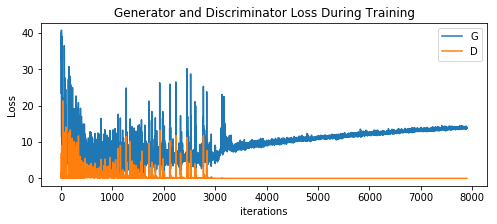

In [15]:
plt.figure(figsize=(8,3))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trainer.g_losses,label="G")
plt.plot(trainer.d_losses,label="D")

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(output_root, data_name, 'g_d_loss.png'))
plt.show()

In [16]:
gif_generator(image_dir=os.path.join(output_root, data_name), 
              name_pattern=r'fake_samples_epoch_[\d]+|.png')